In [1]:
import pandas as pd
import numpy as np
import GetPoolData
import ActivelyRebalancedStrategy
import ActiveStrategyFramework
import itertools
import scipy
import plotly
import kaleido
import matplotlib.pyplot as plt
from importlib import reload
import pickle
import datetime
import google.cloud
import os
import pickle

# Create config.py in this directory and enter your own API Tokens
from config import BITQUERY_API_TOKEN, GOOGLE_SERVICE_AUTH_JSON
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_SERVICE_AUTH_JSON

# Data

In [3]:
# Set if data shall be downloaded
DOWNLOAD_DATA              = True
# Dates for price data. These must be month ends
download_price_data_begin  = '2021-12-31'
download_price_data_end    = '2022-07-31'

# Select date ranges for strategy simulation. 
# Note: Uniswap v3 mainnet start was 2021-05-05. Polygon start is 2022-01-01
DATE_BEGIN                 = pd.to_datetime('2021-12-31 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2022-07-31 00:00PM',utc=True)


In [4]:
# Get Swap Data for both mainnet and polygon

if DOWNLOAD_DATA :
    ###################################################################################################
    # POLYGON
    ###################################################################################################
    # 5bp pool:  https://info.uniswap.org/#/polygon/pools/0x45dda9cb7c25131df268515131f647d726f50608
    # 30bp pool: https://info.uniswap.org/#/polygon/pools/0x0e44ceb592acfc5d3f09d996302eb4c499ff8c10
    address            = '0x0e44ceb592acfc5d3f09d996302eb4c499ff8c10'  # 30bp
    token_0_address    = '0x2791bca1f2de4661ed88a30c99a7a9449aa84174'  # USDC
    token_1_address    = '0x7ceb23fd6bc0add59e62ac25578270cff1b9f619'  # WETH
    decimals_0_eth_usdc, decimals_1_eth_usdc = 6,18
    swap_data_polygon = GetPoolData.get_pool_data_bigquery(
        address,
        download_price_data_begin,
        download_price_data_end,
        decimals_0_eth_usdc, decimals_1_eth_usdc,
        network = 'polygon')
    ###################################################################################################
    # Mainnet
    ###################################################################################################
    # 5bp pool:  https://info.uniswap.org/#/pools/0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
    # 30bp pool: https://info.uniswap.org/#/pools/0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8
    address            = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'  # 30bp
    token_0_address    = '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'  # USDC
    token_1_address    = '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'  # WETH
    swap_data_mainnet = GetPoolData.get_pool_data_bigquery(
        address,
        download_price_data_begin,
        download_price_data_end,
        decimals_0_eth_usdc, decimals_1_eth_usdc,
        network = 'mainnet')
    ###################################################################################################
    pickle.dump( {'swap_data_polygon': swap_data_polygon, 'swap_data_mainnet': swap_data_mainnet},
              open( "/tmp/usdcweth_30bp_polygon_mainnet.p", "wb" ) )
else :
    X = pickle.load( open( "/tmp/usdcweth_30bp_polygon_mainnet.p", "rb" ) )
    swap_data_polygon = X['swap_data_polygon']
    swap_data_mainnet = X['swap_data_mainnet']
    
print(len(swap_data_polygon))
print(len(swap_data_mainnet))

175172
117141


In [5]:
DECIMALS_0, DECIMALS_1 = 6,18
FEE_TIER              = 0.0030

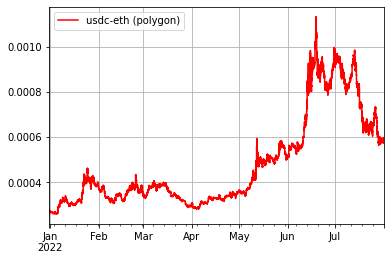

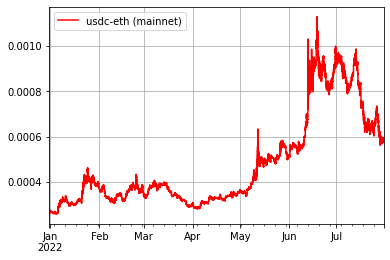

In [6]:
def clean_swap_data(swap_data, network):
    z_score_cutoff                           = 5
    window_size                              = 60*12

    # Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
    STRATEGY_FREQUENCY                       = 'M' # evaluate the strategy every minute
    simulate_data_filtered                   = ActiveStrategyFramework.aggregate_price_data(swap_data,STRATEGY_FREQUENCY)
    simulate_data_filtered_roll              = simulate_data_filtered.quotePrice.rolling(window=window_size) 
    simulate_data_filtered['roll_median']    = simulate_data_filtered_roll.median()
    roll_dev                                 = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median)
    simulate_data_filtered['median_abs_dev'] = 1.4826*roll_dev.rolling(window=window_size).median()
    outlier_indices                          = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median) >= z_score_cutoff*simulate_data_filtered['median_abs_dev']
    simulate_data_price                      = simulate_data_filtered[~outlier_indices]['quotePrice'][DATE_BEGIN:DATE_END]

    %matplotlib inline

    price_chart = pd.DataFrame({'usdc-eth (%s)'%network: simulate_data_filtered['quotePrice']})
    price_chart = price_chart.rename_axis(index={'time_pd':'time'})
    price_chart.plot(color='red')
    plt.grid()
    plt.show()
    
    return simulate_data_price

simulate_data_price_polygon = clean_swap_data(swap_data_polygon, 'polygon')
simulate_data_price_mainnet = clean_swap_data(swap_data_mainnet, 'mainnet')

# Strategy

### Strategy description

Parameters: 

- ```base_order_width```, ```base_order_width_large```, ```limit_order_width```, ```limit_order_width_large```  see below
- ```alpha```, ```alpha_large```: reset range half-width

We first place the base order. If the directional signal is 0, the half-width in both directions is ```base_order_width```. If the signal is +1 or -1, the half-width of the base_order on one side is ```base_order_width``` and on the other side is ```base_order_width_large``` such that we are more likely to keep the desired token. Similarly, for we place the limit order for the remaining token balance (either all token0 or all token1) and choose either ```limit_order_width``` or ```limit_order_width_large```, depending on the directional signal. Same logic for the reset range half-width ```alpha``` and ```alpha_large```.

### Run

In [7]:
reload(ActivelyRebalancedStrategy)
reload(ActiveStrategyFramework)

<module 'ActiveStrategyFramework' from '/home/smart/new_auction/main/notebooks/GammaStrategies/active-strategy-framework-main/ActiveStrategyFramework.py'>

In [ ]:
# For the setup, we assume we place a 50/50 $100 USDC + the equivalent WETH into the pool, 
# for a total $200 USD value deposit. 

In [8]:
# Strategy parameters
# ------------------------------------------------------------------------------------------
base_order_width        = 0.0150
base_order_width_large  = 0.5000
limit_order_width       = 0.0075
limit_order_width_large = 0.5000
alpha                   = 0.0050
alpha_large             = 0.5000
# ------------------------------------------------------------------------------------------
INITIAL_TOKEN_0            = 100

In [11]:
# Strategy sim POLYGON
# ------------------------------------------------------------------------------------------
# Initial Position Details
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price_polygon[0]
# ------------------------------------------------------------------------------------------
parameter_names = ['base_order_width',
                   'base_order_width_large',
                   'limit_order_width', 
                   'limit_order_width_large', 
                   'alpha',
                   'alpha_large'
                  ]
sim_results, sim_performance  = [], []
j = base_order_width, base_order_width_large, \
    limit_order_width, limit_order_width_large, \
    alpha, alpha_large
strategy_polygon = ActivelyRebalancedStrategy.ActivelyRebalancedStrategy(*j)
# ------------------------------------------------------------------------------------------
simulated_strategy_polygon  = ActiveStrategyFramework.simulate_strategy(
    simulate_data_price_polygon, swap_data_polygon, strategy_polygon, 
    INITIAL_TOKEN_0, INITIAL_TOKEN_1, FEE_TIER, DECIMALS_0, DECIMALS_1)
sim_data_polygon = ActiveStrategyFramework.generate_simulation_series(
    simulated_strategy_polygon, strategy_polygon)
strat_result_polygon = ActiveStrategyFramework.analyze_strategy(sim_data_polygon)
# ------------------------------------------------------------------------------------------
for k in range(0,len(parameter_names)) : strat_result_polygon[parameter_names[k]] = j[k]    

In [12]:
# Strategy sim MAINNET
# ------------------------------------------------------------------------------------------
# Initial Position Details
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price_mainnet[0]
# ------------------------------------------------------------------------------------------
parameter_names = ['base_order_width',
                   'base_order_width_large',
                   'limit_order_width', 
                   'limit_order_width_large', 
                   'alpha',
                   'alpha_large'
                  ]
sim_results, sim_performance  = [], []
j = base_order_width, base_order_width_large, \
    limit_order_width, limit_order_width_large, \
    alpha, alpha_large
strategy_mainnet = ActivelyRebalancedStrategy.ActivelyRebalancedStrategy(*j)
simulated_strategy_mainnet  = ActiveStrategyFramework.simulate_strategy(
    simulate_data_price_mainnet, swap_data_mainnet, strategy_mainnet, 
    INITIAL_TOKEN_0, INITIAL_TOKEN_1, FEE_TIER, DECIMALS_0, DECIMALS_1)
sim_data_mainnet = ActiveStrategyFramework.generate_simulation_series(
    simulated_strategy_mainnet, strategy_mainnet)
strat_result_mainnet = ActiveStrategyFramework.analyze_strategy(sim_data_mainnet)
for k in range(0,len(parameter_names)) : strat_result_mainnet[parameter_names[k]] = j[k]    

,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,sharpe_ratio,impermanent_loss,final_value
Polygon,212,12.800323,7.434708,3.09581,1.798114,2921,0.693283,9.163616,2.849121,559.622861


,base_order_width,base_order_width_large,limit_order_width,limit_order_width_large,alpha,alpha_large
Polygon,0.015,0.5,0.0075,0.5,0.005,0.5


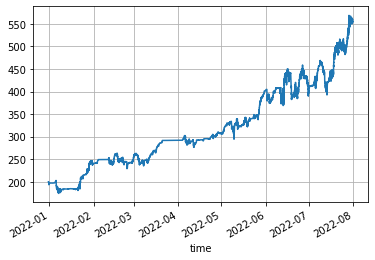

In [23]:
# Results polygon 
################################################################################### 
ind = "Polygon"
DS = sim_data_polygon
strat_result = strat_result_polygon
display(pd.DataFrame(strat_result, index=[ind])[['days_strategy','gross_fee_apr','gross_fee_return','net_apr','net_return','rebalances','max_drawdown','sharpe_ratio','impermanent_loss','final_value']])
display(pd.DataFrame(strat_result, index=[ind])[parameter_names]) 
(DS['value_position_usd']).plot()
plt.grid()
plt.show()

,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,sharpe_ratio,impermanent_loss,final_value
Mainnet,211,21.96855,12.699628,5.57906,3.225155,3340,0.787445,11.116268,4.835478,845.031092


,base_order_width,base_order_width_large,limit_order_width,limit_order_width_large,alpha,alpha_large
Mainnet,0.015,0.5,0.0075,0.5,0.005,0.5


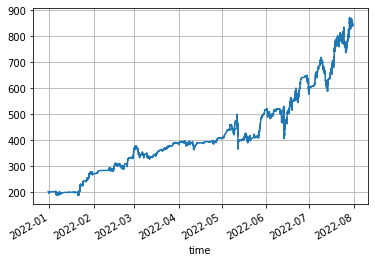

In [24]:
# Results Mainnet 
################################################################################### 
ind = "Mainnet"
DS = sim_data_mainnet
strat_result = strat_result_mainnet
display(pd.DataFrame(strat_result, index=[ind])[['days_strategy','gross_fee_apr','gross_fee_return','net_apr','net_return','rebalances','max_drawdown','sharpe_ratio','impermanent_loss','final_value']])
display(pd.DataFrame(strat_result, index=[ind])[parameter_names]) 
(DS['value_position_usd']).plot()
plt.grid()
plt.show()

In [15]:
#Check that never tokens leftover 
print(abs(sim_data_mainnet['token_0_left_over']).sum())
print(abs(sim_data_mainnet['token_1_left_over']).sum())
print(abs(sim_data_polygon['token_0_left_over']).sum())
print(abs(sim_data_polygon['token_1_left_over']).sum())

4.4448719541997457e-07
2.64442205352358e-10
3.278354261410251e-07
2.678135738128204e-10


MAINNET


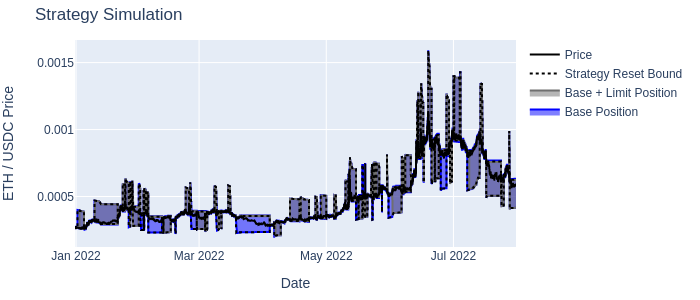

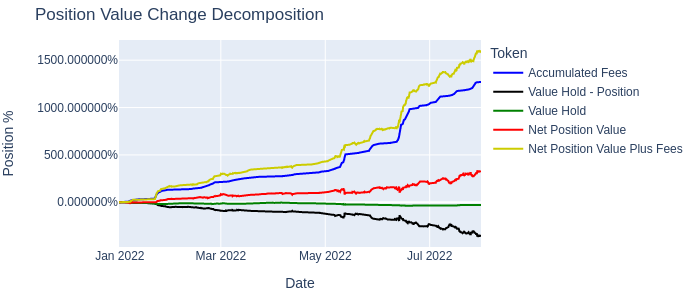

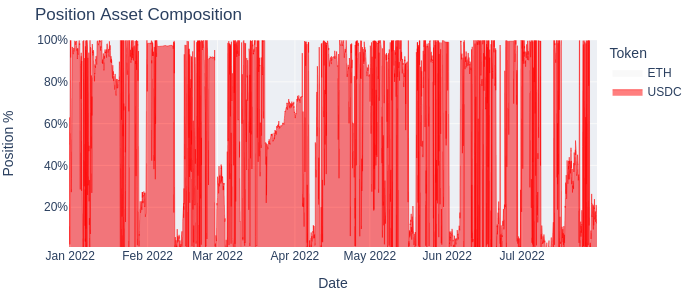

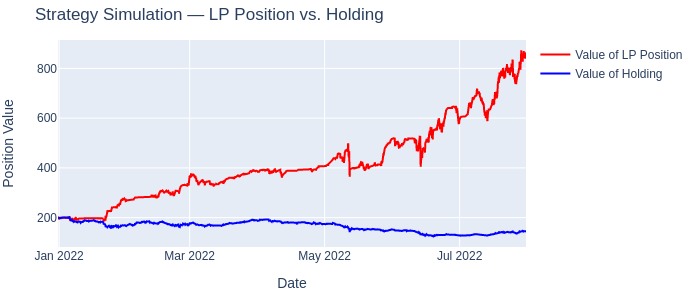

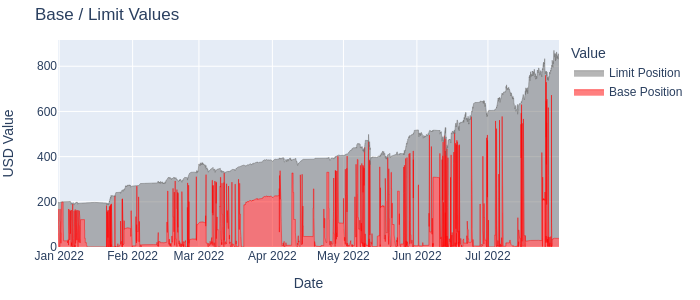

In [16]:
if True : # Charts MAINNET
    print("MAINNET")
    DS = sim_data_mainnet
    
    # 1 - Plot the strategy ranges against the actual price
    p = ActiveStrategyFramework.plot_strategy(DS,'ETH / USDC Price','#0000FF')

    # 2 - Return Decomposition, i.e. plot the value of the position over time, decomposing 
    # the return into fee income vs. impermanent loss (this is an approximation, as this simulator 
    # compounds fees, making the calculation tougher).
    p = ActiveStrategyFramework.plot_position_return_decomposition(DS)

    # 3 - Asset Composition: Plot the composition of assets of the LP position over time.
    p = ActiveStrategyFramework.plot_asset_composition(DS,'USDC','ETH')

    # 4 - Performance Comparison: Plot the value of the LP position vs. holding the initial assets.
    p= ActiveStrategyFramework.plot_position_value(DS)

    # 5 - Position Composition: Plot the relative sizes of the base vs. limit positions
    p = ActiveStrategyFramework.plot_position_composition(DS)

POLYGON


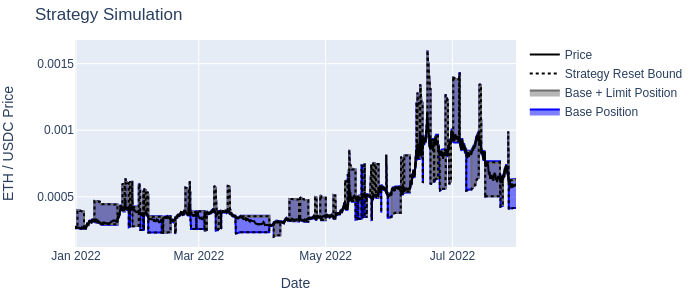

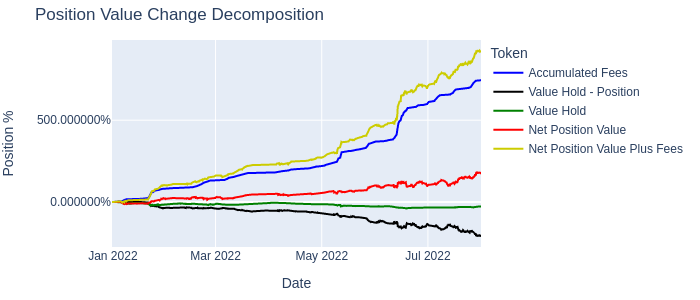

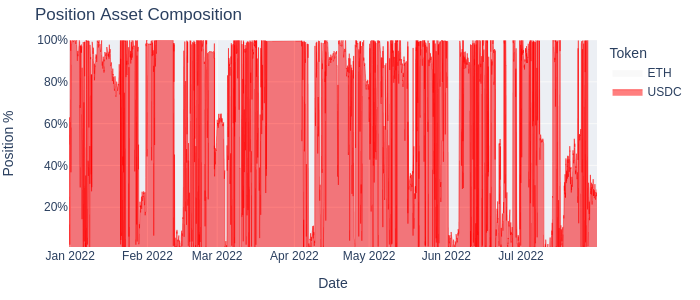

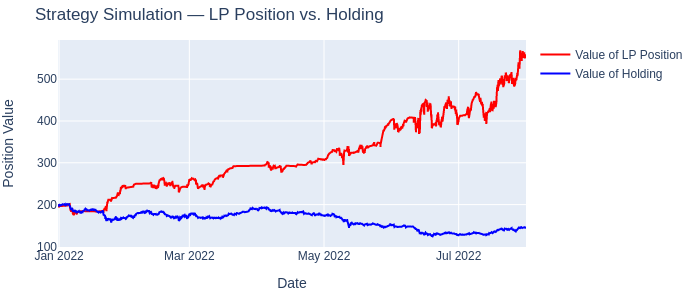

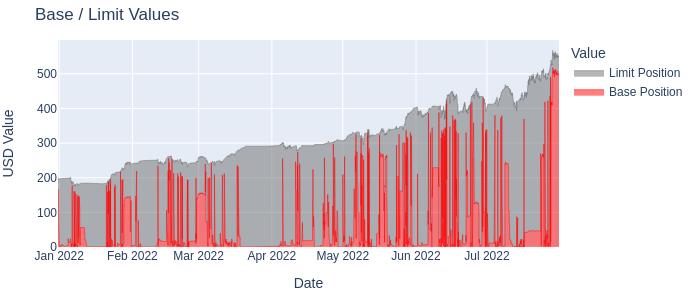

In [20]:
if True : # Charts POLYGON 
    print("POLYGON")
    
    DS = sim_data_polygon
    
    # 1 - Plot the strategy ranges against the actual price
    p = ActiveStrategyFramework.plot_strategy(DS,'ETH / USDC Price','#0000FF')

    # 2 - Return Decomposition, i.e. plot the value of the position over time, decomposing 
    # the return into fee income vs. impermanent loss (this is an approximation, as this simulator 
    # compounds fees, making the calculation tougher).
    p = ActiveStrategyFramework.plot_position_return_decomposition(DS)

    # 3 - Asset Composition: Plot the composition of assets of the LP position over time.
    p = ActiveStrategyFramework.plot_asset_composition(DS,'USDC','ETH')

    # 4 - Performance Comparison: Plot the value of the LP position vs. holding the initial assets.
    p= ActiveStrategyFramework.plot_position_value(DS)

    # 5 - Position Composition: Plot the relative sizes of the base vs. limit positions
    p = ActiveStrategyFramework.plot_position_composition(DS)